In [1]:
import sys 
import matplotlib.pyplot as plt
import pandas as pd 
import plotly.express as px
import json
import seaborn as sns
from datetime import datetime
from datasets import load_dataset ,Dataset
import tqdm as tqdm
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split ,KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
#install dtreeviz and graphviz
import dtreeviz
import shap
sys.path.append('./src/utils')
import general_utils as gu
from regression_utils import multi_one_hot_encode_columns, create_train_test_split, load_books_movies, merge_and_clean_sim, books_features_preprocessing


## Loading the Data

In [2]:
#Data set created in books movies cleaning
data = gu.load_final_dataset()

#Unique books is later used to plot different Authors so it contains only one row per book id 
unique_books = data[['length', 'book_id', 'BookTitle', 'Author', 'normalized_rating_y', 'BookYear', 'review_count']].drop_duplicates(subset='book_id')

#Dataset used for regression, prepared in books movies cleaning
regression_dataset_tmdb_raw_df = load_dataset("ada-datadruids/regression_dataset_tmdb")['train'].to_pandas()

#Dataset with precomputed similarity scores 
similarites = load_dataset("ada-datadruids/bookfilm_summaries_with_similarity_and_sentiment")
similarites_df = similarites['train'].to_pandas()

# Used in linear book regression and Final Regression 
book_genres = pd.read_csv('./data/book_genres.csv')

## Data Visualization

### Scatter Plot to compare ratings of books and movies

In [3]:
labels={ 'normalized_rating_x': 'Normalized Movie Rating', 'normalized_rating_y': 'Normalized Book Rating'}
gu.px_scatter_plot(data,'normalized_rating_x','normalized_rating_y','movie_name', 'Movie Rating vs. Book Ratings', labels)

One can see that most book and movie ratings are around 0.6 which is around 3 stars in the standard 5 star rating system. This seem very reasonable. Additionally, there seems to be a positive correlation between book and movie ratings, which was expected.

### Book Length Distribution

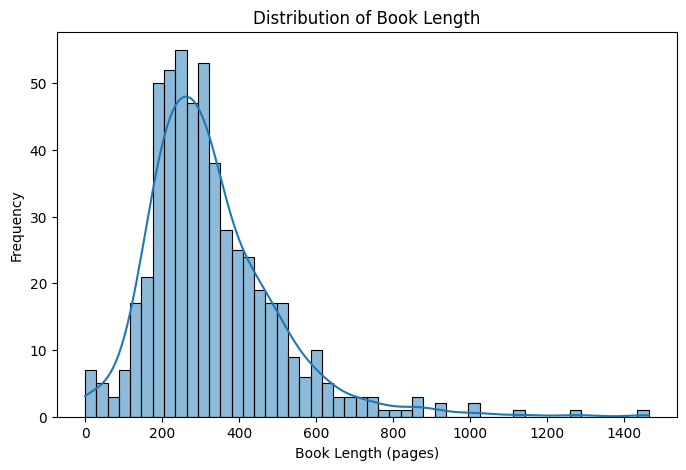

In [4]:

plt.figure(figsize=(8, 5))
sns.histplot(unique_books['length'], bins=50, kde=True)
plt.title('Distribution of Book Length')
plt.xlabel('Book Length (pages)')
plt.ylabel('Frequency')
plt.show()

This graph shows what one would expect, an average book is between 200 and 400 pages. This range is also present here which means that the data can be assumed correct on a first assumption.

### Comparison of Revenue with Book and Movie Ratings

In [5]:
labels = {'revenue': 'Movie Revenue ($), logscale', 'normalized_rating_y': 'Normalized Book Rating'}
gu.px_scatter_plot(data,'revenue','normalized_rating_y','movie_name', 'Revenue vs. Book Ratings', labels, width=900 ,xaxis_type="log")

This plot shows the general behaviour that movie revenue is slightly correlated with the book ratings.

In [6]:
# We want to check which movies are successful based on the two characteristics revenue and movie ratings. We will show four quadrants each containing about a quarter of movies. 
gu.quadrant_revenue(data, 'revenue', title='Revenue vs. Movie Ratings')

The four categories that have been defined are dependend on the median movie ratings and the median movie revenues. This gives four categories of movies measured on the success metrics that were defined in the project description. There may be some essential differences between movies in the different quadrants of this plot that should be investigated further.

### Revenue Adaptation for inflation
We use the same approach as discussed in this article: https://towardsdatascience.com/adjusting-prices-for-inflation-in-pandas-daaaa782cd89 

We use the data from here: https://fred.stlouisfed.org/series/CPIAUCNS 

In [7]:
df_revenue = gu.adjust_for_inflation(data, ['revenue','budget'],cpiaucns_path='./data/CPIAUCNS.csv' ,title='BookTitle', is_plotting_enabled=True)

With this inflation-adjustment trends can be visualized related to the cost of living at that momnent. This shows that the trend of increasing revenues is much less present than initially thought. Another thing that can be seen is the increase in movies at around 1980. After 1980 it seems that movies have a much harder time to make a lot of money. This may also arise because of a bias in the dataset which leads to only successful old movies being included.

### Let's plot the categories with Inflations-Adjustment

In [8]:
gu.quadrant_revenue(df_revenue, 'adjusted_revenue', title='Adjusted Revenue vs. Movie Ratings')

The inflation-adjustment has little impact on this particular plot. The main thing that can be seen is a shift to the right, so a general increase in revenues. Which comes from the fact that the inflation was adjusted to the value of today's money, rather than to the money from the past. 

### Top 10 Authors with the most different Books adapted into Movies

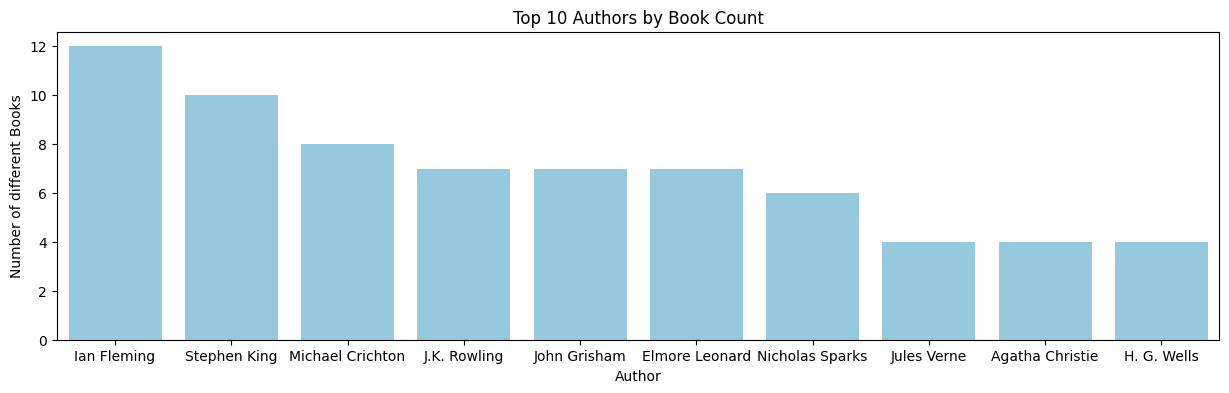

In [9]:
unique_books_author = unique_books[unique_books.Author != '0']
author_stats = unique_books_author.groupby('Author').agg(book_count=('BookTitle', 'size')).sort_values(by='book_count', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(15, 4))
sns.barplot(x=author_stats.index, y=author_stats['book_count'], color='skyblue', ax=ax1)
ax1.set_ylabel('Number of different Books')
ax1.set_xlabel('Author')
ax1.set_title('Top 10 Authors by Book Count')
plt.show()

Zane Grey seems to have understood the way of writing books that are later made into movies. While he is mainly known for western movies, Ian Fleming has gotten to his spot by writing all the "James Bond" books. Stephen King is on a well deserved third place with all of his horror movies. This plot shows, that most authors that write books which are adapted often, only write for a very specific niche. This is a sort of winner takes it all effect, which means that in some genres there is one author that will probably have all his books turned into films while most other authors are overlooked.

### Release Year of the Book

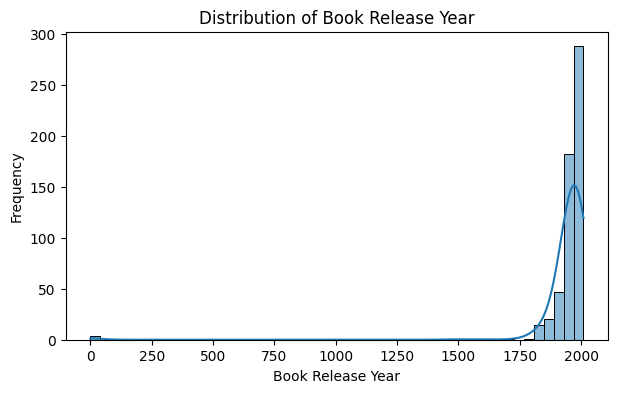

In [10]:
plt.figure(figsize=(7, 4))
sns.histplot(unique_books['BookYear'].dropna(), bins=50, kde=True)
plt.title('Distribution of Book Release Year')
plt.xlabel('Book Release Year')
plt.ylabel('Frequency')
plt.show()

In [11]:
display(unique_books[unique_books.BookYear <= 50])

,length,book_id,BookTitle,Author,normalized_rating_y,BookYear,review_count
692,224.0,25309336.0,The Rebel Outlaw: Josey Wales,Asa Earl Carter,0.686667,0,52.0
818,320.0,13109354.0,One Thousand and One Nights,0,0.596667,0,211.0
1337,541.0,1381.0,Odyssey,Homer,0.583333,0,9990.0
1370,213.0,52357.0,Beowulf,unknown,0.476667,0,5648.0


Some of these books are actually written a very long time ago (like Odyssey from Homer for example was written around 700 B.C.), but others just don't seem to have the correct year (like Background to Danger from 1937). Let's exclude them for now from the analysis, since they are only a few. 

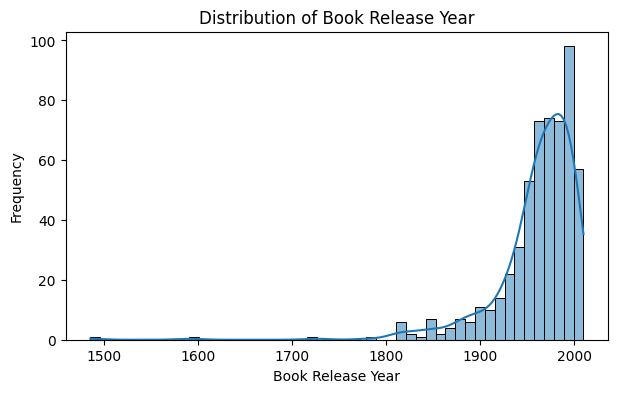

In [12]:
unique_books_year = unique_books[unique_books.BookYear != 0]
plt.figure(figsize=(7, 4))
sns.histplot(unique_books_year['BookYear'].dropna(), bins=50, kde=True)
plt.title('Distribution of Book Release Year')
plt.xlabel('Book Release Year')
plt.ylabel('Frequency')
plt.show()

Now the graph is more useful. Most books that were turned into movies were written in the 19th century. This mainly comes form an increase in book publishing since more people had the time and money to spend on writing. 

### How much time goes by between a Book and Movie Release?

In [13]:
year_book_movie = data.dropna(subset=['BookYear', 'movie_year'])
year_book_movie = year_book_movie[year_book_movie['BookYear']!=0]
year_book_movie['years_to_movie'] = year_book_movie['movie_year'] - year_book_movie['BookYear']


labels={'BookYear': 'Book Release Year', 'years_to_movie': 'Years to Movie Release'}
hover_data={'BookTitle': True, 'BookYear': True, 'movie_year': True, 'years_to_movie': True}
gu.px_scatter_plot(year_book_movie,'movie_year','years_to_movie','movie_name', 'Revenue vs. Book Ratings', labels, height=400, width=1200, update_traces=True, hover_data=hover_data)



There seems to be something weird going on for the Tarzan movies... After some quick research, we found out that while in 1995 the last written work for a Tarzan novel was found, the original books were released much sooner. 

### Summary Similarity Distribution

,movie_id,book_title,movie_name,book_summary,film_summary,similarity,film_sentiment,film_sentiment_score,book_sentiment,book_sentiment_score
0,196176,The Siege of Trencher's Farm,Straw Dogs,"George Magruder, an American professor of Eng...","David Sumner , a timid American mathematician,...",0.451876,positive,0.333608,positive,0.994480
1,6703617,Journey to the West,The Forbidden Kingdom,The novel has 100 chapters. These can be divi...,"In this film, which is based loosely on the an...",0.559594,positive,0.995482,positive,0.995404
2,24416479,The Beast Master,Beastmaster 2: Through the Portal of Time,"It tells the story of Hosteen Storm, an ex-so...","Dar, the Beastmaster , is back and now he has ...",0.344548,positive,0.997562,positive,0.998812
3,9384481,The Blessing,Count Your Blessings,It is set in the post-war World War II period...,While visiting Grace Allingham in wartime Lond...,0.669707,positive,0.996070,positive,0.996607
4,22224559,The Last Song,The Last Song,Veronica “Ronnie” Miller’s life was turned up...,"At seventeen, Veronica ""Ronnie"" Miller remain...",0.852735,positive,0.978184,positive,0.998164


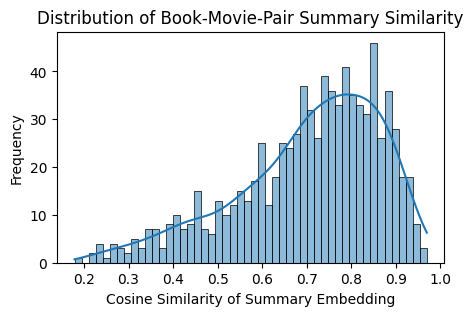

In [14]:
nlp_df = load_dataset("ada-datadruids/bookfilm_summaries_with_similarity_and_sentiment")['train'].to_pandas()
display(nlp_df.head(5))
plt.figure(figsize=(5, 3))
sns.histplot(nlp_df['similarity'], bins=50, kde=True)
plt.title('Distribution of Book-Movie-Pair Summary Similarity')
plt.xlabel('Cosine Similarity of Summary Embedding')
plt.ylabel('Frequency')
plt.show()


The summary similarity between books and movies is quite high. There are however also quite a few summaries where the movie and book seem to differ a lot. Which of these movie-book pairs performed better or worse have not yet been analysed, but there will surely be some interesting conclusions to make.

### Sentiment Analysis

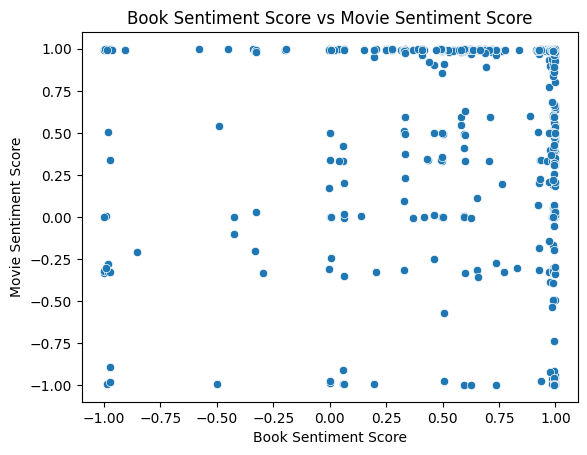

In [15]:
sns.scatterplot(x=nlp_df['book_sentiment_score'], y=nlp_df['film_sentiment_score'])

plt.xlabel('Book Sentiment Score')
plt.ylabel('Movie Sentiment Score')

plt.title('Book Sentiment Score vs Movie Sentiment Score')
plt.show()

This plot has no visual correlations between book and movie sentiment scores. One would expect to have quite a clear correlation of the movies were direct adaptations of the books, since this is not the case, some further investigation is needed.

## Linear Regression 

### Create Datasets for the following steps

In [16]:
print(regression_dataset_tmdb_raw_df['based_on_book'].value_counts())
regression_dataset_tmdb_raw_df = gu.adjust_for_inflation(regression_dataset_tmdb_raw_df, ['budget', 'revenue'], is_plotting_enabled=False)

based_on_book
False    7694
True      659
Name: count, dtype: int64


In [17]:
# Drop the columns that are not relevant for the regression, drop revenue and budget,
# because in the previous step two new columns have been added: adjusted revenue and adjusted budget 
# production companies removed as there are over 100'000 unique values
regression_dataset_tmdb_raw_df.drop(columns=['keywords', 'release_date', 'backdrop_path', 'homepage', 'original_title', 'overview', 'poster_path', 'tagline', 'production_companies', 'original_language','revenue','budget', 'imdb_id'], inplace=True)

matching_dataset_processed_df = multi_one_hot_encode_columns(
    regression_dataset_tmdb_raw_df,
    column_names_mohe=['genres', 'spoken_languages', 'production_countries'], # keywords not taken for now
    column_names_ohe=['status'],
)

# Keep the id in the matching dataset, which will be used later for the matching step, the id is not used for the scatter plot 
scatter_plot_data_regression_dataset_df= matching_dataset_processed_df.drop(columns=['id'])

#The title is used for scatter plot but not for regression, therefore we should drop it in addition to the id 
regression_dataset_processed_df=scatter_plot_data_regression_dataset_df.drop(columns=['title'])

#Drop the title form the matching dataset but keep the id, this will be used for the last regression done in this notebook
#The dataset is already created here, because we need the multi one hot encoding, but not the title, but we have to keep the id for merging 
final_regression_dataset = matching_dataset_processed_df.drop(columns=['title'])

### Find Relation Between Budget and Revenue

In [ ]:
#The budget probably has a big influence on the revenue. We plot the relationship between the two, to see if it is linear (and could thus be captured by linear regression)
labels={'adjusted_budget': 'Budget', 'adjusted_revenue': 'Revenue'}
gu.px_scatter_plot(scatter_plot_data_regression_dataset_df,'adjusted_budget','adjusted_revenue','title', 'Budget vs Revenue', labels,height=650,xaxis_type='log', yaxis_type='log')


In [ ]:
# Create a new column for the revenue/budget ratio
scatter_plot_data_regression_dataset_df['revenue_to_budget_ratio'] = (
    scatter_plot_data_regression_dataset_df['adjusted_revenue'] / scatter_plot_data_regression_dataset_df['adjusted_budget']
)

labels={'adjusted_budget': 'Budget', 'revenue_to_budget_ratio': 'Revenue-to-Budget Ratio'}
# Create a scatter plot of revenue/budget ratio vs budget
gu.px_scatter_plot(scatter_plot_data_regression_dataset_df,'adjusted_budget','revenue_to_budget_ratio','title', 'Revenue-to-Budget Ratio vs Budget', labels,height=650,xaxis_type='log', yaxis_type='log')

### Dataset Split

First, the Dataset is split in two different ways, so that movies that are based on books can be analysed separately from movies that are not based on books. 

First Split:
- Case 1: Take the whole dataset, don't separate based on book and not based on book 

Second Split: 
- Case 2: Only consider Movies based on Books (Bobs)
- Case 3: Only consider Movies not based on Books (Nobs)

In [ ]:
# Standardise and split the dataset into train and test set taking into account movies based on books and movies not based on books 
X_train, X_test, y_train, y_test = create_train_test_split(
    regression_dataset_processed_df, 
    target_column='adjusted_revenue', 
    should_split_based_on_book=False, 
    test_size=0.2, 
    seed=42
)['all']

'''
Because the flag should_split_based_on_book is set to True in the function create_train_test_split, the dataset will 
first be separated into BOBs and NOBs. This assures that the resulting test and train data sets will have the 
specified sizes for each part of the dataset resepectively. 
'''
#Standardise and Split Dataset into train on test set according to if movies are based on book or not 
split_dict = create_train_test_split(
    regression_dataset_processed_df,
    target_column='adjusted_revenue',
    should_split_based_on_book=True,
    test_size=0.2,
    seed=42
)
X_train_based_on_book, X_test_based_on_book, y_train_based_on_book, y_test_based_on_book = split_dict['based_on_book']
X_train_not_based_on_book, X_test_not_based_on_book, y_train_not_based_on_book, y_test_not_based_on_book = split_dict['not_based_on_book']

### Revenue Approach

#### Non Separated (based on book or not)

In the revenue approach the target variable is the revenue. Linear regression is used to see how important different features are for the prediction of the revenue. 

In [22]:
results = gu.perform_linear_regression(X_train, X_test, y_train, y_test)
results.summary()

RMSE value: 137285894.11512282


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     125.0
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:40:52   Log-Likelihood:            -1.3503e+05
No. Observations:                6675   AIC:                         2.702e+05
Df Residuals:                    6625   BIC:                         2.705e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                          8.612e+07   1.81e+06     47.488      0.000    8.26e+07    8.97e+07
vote_average                                  -1.242e+06   2.11e+06     -0.589      0.556   -5.38e+06    2.89e+06
vote_count                                     8.722e+07   2.82e+06     30.887      0.000    8.17e+07    9.28e+07
runtime                                        1.229e+07   2.29e+06      5.364      0.000     7.8e+06    1.68e+07
adult                                          3.329e+06   1.83e+06      1.823      0.068   -2.52e+05    6.91e+06
popularity                                     1.694e+07   2.91e+06      5.829      0.000    1.12e+07    2.26e+07
based_on_book                                  5.274e+06   1.92e+06      2.750      0.006    1.51e+06    9.03e+06
movie_year                                    -2.803e+07   2.04e+06    -13.760      0.000    -3.2e+07    -2.4e+07
adjusted_budget                                5.687e+07   2.55e+06     22.305      0.000    5.19e+07    6.19e+07
genres_count                                  -2.821e+07   1.42e+07     -1.989      0.047    -5.6e+07   -4.06e+05
genres_Action                                  1.281e+07   5.83e+06      2.197      0.028    1.38e+06    2.42e+07
genres_Adventure                               1.537e+07   5.25e+06      2.927      0.003    5.08e+06    2.57e+07
genres_Animation                               1.228e+07   3.58e+06      3.427      0.001    5.26e+06    1.93e+07
genres_Comedy                                   1.21e+07   6.45e+06      1.875      0.061   -5.49e+05    2.47e+07
genres_Crime                                   1.173e+06   5.01e+06      0.234      0.815   -8.66e+06     1.1e+07
genres_Documentary                             7.986e+06   2.63e+06      3.034      0.002    2.83e+06    1.31e+07
genres_Drama                                   9.694e+06   6.79e+06      1.428      0.153   -3.61e+06     2.3e+07
genres_Family                                  1.281e+07   4.32e+06      2.966      0.003    4.35e+06    2.13e+07
genres_Fantasy                                 2.912e+06   3.99e+06      0.730      0.466   -4.91e+06    1.07e+07
genres_History                                -4.296e+05   3.26e+06     -0.132      0.895   -6.83e+06    5.97e+06
genres_Horror                                   6.59e+06   4.35e+06      1.514      0.130   -1.94e+06    1.51e+07
genres_Music                                   5.326e+06   3.21e+06      1.661      0.097   -9.59e+05    1.16e+07
genres_Mystery                                 4.201e+06   3.95e+06      1.065      0.287   -3.53e+06    1.19e+07
genres_Romance                                 1.392e+07    5.5e+06      2.530      0.011    3.14e+06    2.47e+07
genre

In [23]:
gu.create_error_plot_regression(results,"Relationship Strength of Nobs and Bobs")

It can be seen that the linear regression has an $R^{2}$ value of the model is only 0.48. However, our goal is not to predict revenue with a high precision but instead figure out which parameters are most important for a movies success. The plot above shows that the number of votes as well as the budget have a high influence on the revenue. The movie year has a negative influence. We can interpret this in the way that nowadays there are some very high revenue generating movies but also many not very high revenue movies. 

### Separated (Based on Books or not)

To make sure that parameters that are important for all movies are also important for the subset of movies that are based on books, we split the dataset into two groups and redo the linear regression fitting. 

In [ ]:
results = gu.perform_linear_regression(X_train_based_on_book, X_test_based_on_book, y_train_based_on_book, y_test_based_on_book)
results.summary()

RMSE value: 610122137.1127033


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     17.55
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           3.61e-76
Time:                        14:40:53   Log-Likelihood:                -10655.
No. Observations:                 526   AIC:                         2.140e+04
Df Residuals:                     479   BIC:                         2.160e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                          1.719e+08   6.93e+06     24.800      0.000    1.58e+08    1.86e+08
vote_average                                  -8.681e+05      1e+07     -0.086      0.931   -2.06e+07    1.89e+07
vote_count                                     9.268e+07   1.35e+07      6.886      0.000    6.62e+07    1.19e+08
runtime                                        2.831e+07   9.89e+06      2.862      0.004    8.88e+06    4.78e+07
adult                                          -8.24e-08   5.55e-08     -1.484      0.139   -1.92e-07    2.67e-08
popularity                                     6.407e+07   1.28e+07      4.994      0.000    3.89e+07    8.93e+07
movie_year                                    -5.585e+07   8.68e+06     -6.436      0.000   -7.29e+07   -3.88e+07
adjusted_budget                                 5.82e+07   9.62e+06      6.047      0.000    3.93e+07    7.71e+07
genres_count                                  -6.536e+07   4.45e+07     -1.469      0.142   -1.53e+08    2.21e+07
genres_Action                                   3.88e+07   2.04e+07      1.899      0.058   -1.34e+06    7.89e+07
genres_Adventure                               5.206e+07   2.29e+07      2.277      0.023    7.14e+06     9.7e+07
genres_Animation                                2.47e+07   1.36e+07      1.822      0.069   -1.93e+06    5.13e+07
genres_Comedy                                  3.428e+07   1.84e+07      1.859      0.064   -1.96e+06    7.05e+07
genres_Crime                                   1.022e+07   1.77e+07      0.579      0.563   -2.45e+07    4.49e+07
genres_Documentary                             3.822e-08   3.55e-08      1.077      0.282   -3.15e-08    1.08e-07
genres_Drama                                   1.122e+07   2.41e+07      0.466      0.641   -3.61e+07    5.85e+07
genres_Family                                  1.408e+07   1.77e+07      0.797      0.426   -2.06e+07    4.88e+07
genres_Fantasy                                 1.051e+07   1.72e+07      0.611      0.542   -2.33e+07    4.43e+07
genres_History                                 8.669e+05   1.26e+07      0.069      0.945   -2.39e+07    2.57e+07
genres_Horror                                  1.464e+07   1.54e+07      0.951      0.342   -1.56e+07    4.49e+07
genres_Music                                  -3.888e+05   8.77e+06     -0.044      0.965   -1.76e+07    1.68e+07
genres_Mystery                                 8.461e+06   1.66e+07      0.510      0.610   -2.42e+07    4.11e+07
genres_Romance                                 2.697e+07   2.01e+07      1.340      0.181   -1.26e+07    6.65e+07
genres_Science Fiction                        -8.105e+06   1.65e+07     -0.491      0.624   -4.06e+07    2.44e+07
genre

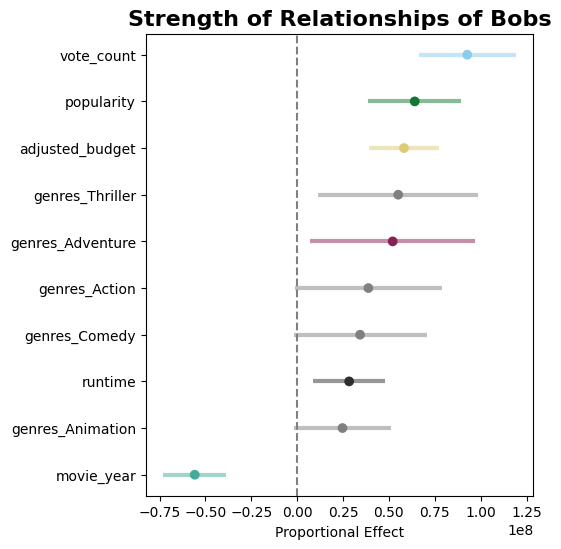

In [ ]:
gu.create_error_plot_regression(results, "Strength of Relationships of Bobs")

The $R^{2}$ value for movies based on books only is much higher than for the entire dataset (0.628). We can also see that the confidence intervals in this plot are much bigger than for the previous one. That can be explained by the fact that the dataset of movies based on books is much smaller. We can see similar tendencies in this dataset compared with before, the movie year also has a negative impact, the vote count the most positibe. Some differences can be seen mostly in the types of genres. This means that some genres (like Thrillers) probably work better for book adaptations than for other movies. 

### Movies Based on Books

In [28]:
results = gu.perform_linear_regression(X_train_not_based_on_book, X_test_not_based_on_book, y_train_not_based_on_book, y_test_not_based_on_book) 
results.summary()

RMSE value: 111052131.93001094


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     162.1
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:40:54   Log-Likelihood:            -1.2317e+05
No. Observations:                6148   AIC:                         2.464e+05
Df Residuals:                    6099   BIC:                         2.468e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                          7.628e+07   1.55e+06     49.075      0.000    7.32e+07    7.93e+07
vote_average                                   4.032e+05   1.81e+06      0.223      0.823   -3.14e+06    3.94e+06
vote_count                                     7.762e+07   2.35e+06     33.038      0.000     7.3e+07    8.22e+07
runtime                                        2.793e+06   2.09e+06      1.336      0.182   -1.31e+06    6.89e+06
adult                                          3.463e+06   1.56e+06      2.215      0.027    3.98e+05    6.53e+06
popularity                                     1.013e+07   2.45e+06      4.139      0.000    5.33e+06    1.49e+07
movie_year                                    -2.438e+07   1.71e+06    -14.253      0.000   -2.77e+07    -2.1e+07
adjusted_budget                                7.727e+07   2.03e+06     38.146      0.000    7.33e+07    8.12e+07
genres_count                                   -2.43e+07   1.19e+07     -2.044      0.041   -4.76e+07   -9.98e+05
genres_Action                                  7.792e+06   4.91e+06      1.588      0.112   -1.83e+06    1.74e+07
genres_Adventure                               8.607e+06   4.26e+06      2.022      0.043    2.62e+05     1.7e+07
genres_Animation                               1.292e+07   3.05e+06      4.231      0.000    6.94e+06    1.89e+07
genres_Comedy                                  1.061e+07   5.48e+06      1.937      0.053   -1.27e+05    2.13e+07
genres_Crime                                   2.945e+06   4.26e+06      0.691      0.490   -5.41e+06    1.13e+07
genres_Documentary                               7.5e+06   2.31e+06      3.245      0.001    2.97e+06     1.2e+07
genres_Drama                                    8.94e+06    5.7e+06      1.570      0.117   -2.22e+06    2.01e+07
genres_Family                                  9.259e+06   3.56e+06      2.603      0.009    2.29e+06    1.62e+07
genres_Fantasy                                 1.538e+06   3.27e+06      0.470      0.638   -4.88e+06    7.95e+06
genres_History                                 9.899e+05   2.79e+06      0.354      0.723   -4.49e+06    6.47e+06
genres_Horror                                  7.553e+06   3.77e+06      2.003      0.045    1.61e+05    1.49e+07
genres_Music                                   2.446e+06   2.78e+06      0.879      0.379   -3.01e+06     7.9e+06
genres_Mystery                                 2.793e+06   3.23e+06      0.864      0.388   -3.54e+06    9.13e+06
genres_Romance                                 1.217e+07   4.64e+06      2.623      0.009    3.07e+06    2.13e+07
genres_Science Fiction                         1.617e+06   3.44e+06      0.470      0.638   -5.13e+06    8.36e+06
genre

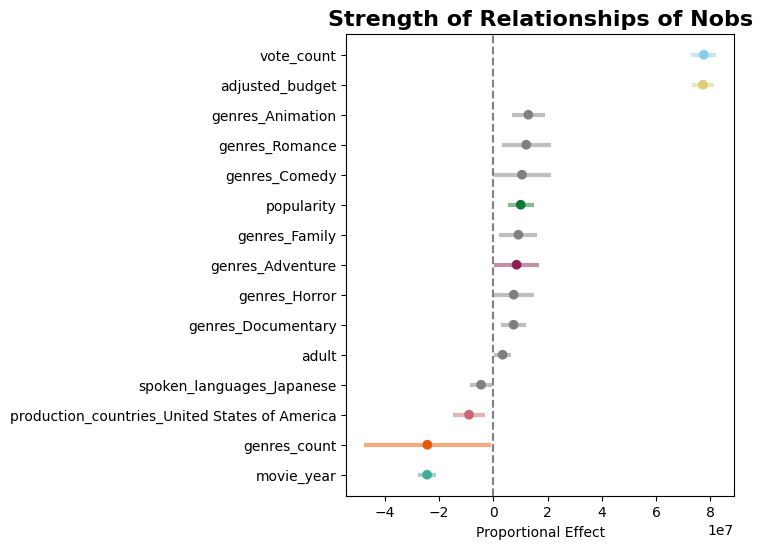

In [ ]:
gu.create_error_plot_regression(results, "Strength of Relationships of Nobs")

This model is fit on only movies that are not based on books. This plot resembles the first plot very closely, which makes sense since most of the dataset is made up of movies that are not based on books. For the datastory we can conclude that most features have a very similar effect on both book adaptations and regular movies, so we will only include the analysis on the entire dataset. 

### Revenue-Budget Fraction Approach

Since we know that the revenue and budget is probably very closely related, we try to fit a linear regression model with the target variable being the ratio between the budget and the revenue. We don't take the profit, since we want a relative measure of the return in investment.

In [30]:
regression_dataset_processed_rb_ration_df = regression_dataset_processed_df.copy(deep=True)
regression_dataset_processed_rb_ration_df = gu.prepare_dataset_for_revbudfrac_approach(regression_dataset_processed_rb_ration_df)

X_train_rbf, X_test_rbf, y_train_rbf, y_test_rbf = create_train_test_split(
    regression_dataset_processed_rb_ration_df,
    target_column='log_rb_ratio',
    should_split_based_on_book=False,
    test_size=0.2,
    seed=42
)['all']

min ratio: -9.206662475599046
max ratio: 485.0724784969183


### Fit model on entire Dataset

In [31]:
results = gu.perform_linear_regression(X_train_rbf, X_test_rbf, y_train_rbf, y_test_rbf)
results.summary()

RMSE value: 1.7126345962054694


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.336
Date:                Fri, 20 Dec 2024   Prob (F-statistic):             0.0607
Time:                        14:40:54   Log-Likelihood:                -21683.
No. Observations:                6675   AIC:                         4.346e+04
Df Residuals:                    6626   BIC:                         4.380e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             1.1574      0.077     15.121      0.000       1.007       1.307
vote_average                                      0.0989      0.089      1.117      0.264      -0.075       0.273
vote_count                                        0.0552      0.115      0.481      0.631      -0.170       0.280
runtime                                          -0.0766      0.096     -0.801      0.423      -0.264       0.111
adult                                             0.3225      0.077      4.183      0.000       0.171       0.474
popularity                                       -0.1188      0.122     -0.975      0.330      -0.358       0.120
based_on_book                                     0.0307      0.081      0.380      0.704      -0.128       0.189
movie_year                                        0.0978      0.086      1.141      0.254      -0.070       0.266
genres_count                                     -0.2552      0.599     -0.426      0.670      -1.429       0.918
genres_Action                                     0.0834      0.246      0.339      0.735      -0.399       0.565
genres_Adventure                                  0.0474      0.221      0.215      0.830      -0.386       0.481
genres_Animation                                 -0.0023      0.151     -0.015      0.988      -0.299       0.294
genres_Comedy                                     0.2251      0.272      0.827      0.408      -0.309       0.759
genres_Crime                                      0.0348      0.212      0.165      0.869      -0.380       0.450
genres_Documentary                               -0.0099      0.111     -0.090      0.929      -0.228       0.208
genres_Drama                                      0.0633      0.286      0.221      0.825      -0.498       0.625
genres_Family                                     0.0890      0.182      0.488      0.625      -0.268       0.446
genres_Fantasy                                    0.0271      0.168      0.161      0.872      -0.303       0.357
genres_History                                    0.0451      0.138      0.328      0.743      -0.225       0.315
genres_Horror                                     0.0973      0.183      0.531      0.596      -0.262       0.457
genres_Music                                      0.0367      0.135      0.271      0.786      -0.229       0.302
genres_Mystery                                    0.0576      0.167      0.346      0.730      -0.269       0.384
genres_Romance                                    0.0568      0.232      0.244      0.807      -0.398       0.512
genres_Science Fiction                            0.0536      0.176      0.304      0.761      -0.292       0.400
genre

### Separate movies in dataset according to if they are based on books or not 

In [32]:
dict = create_train_test_split(
    regression_dataset_processed_rb_ration_df,
    target_column='log_rb_ratio',
    should_split_based_on_book=True,
    test_size=0.2,
    seed=42
)
X_train_BOB_rbf, X_test_BOB_rbf, y_train_BOB_rbf, y_test_BOB_rbf = dict['based_on_book']
X_train_NOB_rbf, X_test_NOB_rbf, y_train_NOB_rbf, y_test_NOB_rbf = dict[
    'not_based_on_book']

#### Fit model for Movies Based on Book

In [33]:
results = gu.perform_linear_regression(X_train_BOB_rbf, X_test_BOB_rbf, y_train_BOB_rbf, y_test_BOB_rbf)
results.summary()

RMSE value: 0.12026766085808


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     1.674
Date:                Fri, 20 Dec 2024   Prob (F-statistic):            0.00513
Time:                        14:40:55   Log-Likelihood:                 113.29
No. Observations:                 526   AIC:                            -134.6
Df Residuals:                     480   BIC:                             61.62
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             1.0516      0.009    118.101      0.000       1.034       1.069
vote_average                                      0.0222      0.013      1.777      0.076      -0.002       0.047
vote_count                                        0.0068      0.017      0.393      0.694      -0.027       0.041
runtime                                          -0.0204      0.012     -1.655      0.099      -0.045       0.004
adult                                         -1.734e-18   1.73e-17     -0.100      0.920   -3.58e-17    3.23e-17
popularity                                        0.0047      0.016      0.288      0.774      -0.027       0.036
movie_year                                       -0.0200      0.011     -1.827      0.068      -0.041       0.002
genres_count                                     -0.0464      0.057     -0.812      0.417      -0.159       0.066
genres_Action                                     0.0120      0.026      0.457      0.648      -0.040       0.064
genres_Adventure                                  0.0235      0.029      0.803      0.423      -0.034       0.081
genres_Animation                                  0.0093      0.017      0.535      0.593      -0.025       0.043
genres_Comedy                                     0.0151      0.024      0.637      0.524      -0.031       0.062
genres_Crime                                      0.0133      0.023      0.587      0.557      -0.031       0.058
genres_Documentary                             3.617e-17   7.77e-17      0.465      0.642   -1.17e-16    1.89e-16
genres_Drama                                      0.0276      0.031      0.892      0.373      -0.033       0.088
genres_Family                                     0.0055      0.023      0.243      0.808      -0.039       0.050
genres_Fantasy                                    0.0038      0.022      0.174      0.862      -0.039       0.047
genres_History                                    0.0043      0.016      0.268      0.789      -0.027       0.036
genres_Horror                                     0.0083      0.020      0.421      0.674      -0.031       0.047
genres_Music                                      0.0054      0.011      0.482      0.630      -0.017       0.028
genres_Mystery                                    0.0040      0.021      0.190      0.849      -0.038       0.046
genres_Romance                                    0.0072      0.026      0.280      0.780      -0.044       0.058
genres_Science Fiction                            0.0071      0.021      0.335      0.738      -0.035       0.049
genres_Thriller                                   0.0124      0.028      0.435      0.664      -0.043       0.068
genre

#### Fit Model for Movies Not based on book

In [34]:
results = gu.perform_linear_regression(X_train_NOB_rbf, X_test_NOB_rbf, y_train_NOB_rbf, y_test_NOB_rbf)
results.summary()

RMSE value: 2.4742517953288656


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.583
Date:                Fri, 20 Dec 2024   Prob (F-statistic):            0.00687
Time:                        14:40:55   Log-Likelihood:                -20174.
No. Observations:                6148   AIC:                         4.044e+04
Df Residuals:                    6100   BIC:                         4.077e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             1.1634      0.082     14.111      0.000       1.002       1.325
vote_average                                      0.0562      0.095      0.589      0.556      -0.131       0.243
vote_count                                        0.0645      0.121      0.533      0.594      -0.173       0.302
runtime                                          -0.0810      0.109     -0.740      0.460      -0.296       0.134
adult                                             0.4128      0.083      4.978      0.000       0.250       0.575
popularity                                       -0.1395      0.129     -1.079      0.281      -0.393       0.114
movie_year                                        0.1205      0.091      1.329      0.184      -0.057       0.298
genres_count                                     -0.1988      0.630     -0.315      0.752      -1.435       1.037
genres_Action                                     0.0577      0.260      0.222      0.825      -0.452       0.568
genres_Adventure                                  0.0312      0.225      0.138      0.890      -0.410       0.473
genres_Animation                                  0.0068      0.162      0.042      0.966      -0.311       0.324
genres_Comedy                                     0.1904      0.291      0.655      0.512      -0.379       0.760
genres_Crime                                      0.0023      0.226      0.010      0.992      -0.441       0.445
genres_Documentary                               -0.0199      0.123     -0.162      0.871      -0.260       0.220
genres_Drama                                      0.0060      0.302      0.020      0.984      -0.586       0.598
genres_Family                                    -0.0036      0.189     -0.019      0.985      -0.373       0.366
genres_Fantasy                                    0.0202      0.173      0.116      0.907      -0.320       0.360
genres_History                                    0.0447      0.148      0.301      0.763      -0.246       0.335
genres_Horror                                     0.0636      0.200      0.318      0.750      -0.328       0.455
genres_Music                                      0.0258      0.148      0.175      0.861      -0.263       0.315
genres_Mystery                                    0.0405      0.171      0.236      0.813      -0.296       0.377
genres_Romance                                   -0.0044      0.246     -0.018      0.986      -0.487       0.478
genres_Science Fiction                            0.0240      0.182      0.131      0.895      -0.334       0.381
genres_Thriller                                   0.0249      0.254      0.098      0.922      -0.473       0.522
genre

### Analysis

The R-squared $R^2$ is calculated as:

$$
R^2 = 1 - \frac{\text{RSS}}{\text{TSS}} = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$
Where:
- RSS is the residual sum of squares
- TSS is the total sum of squares
- $y_i$ represents the actual value,
- $\hat{y}_i$ is the predicted value, and
- $\bar{y}$ is the mean of the actual values.

The formula for $R^2$ essentially measures the proportion of the variance in the target variable that is explained by the model.


> A larger variance in the target variable can result in a higher R-squared score because of how R-squared is calculated and its relationship with the proportion of variance explained by the model.
>
> The formula implies that a larger TSS (total variance) gives the model more room to explain, and hence, if the model does a good job at explaining that variance, it can achieve a higher R-squared.


Therefore, one must also look at the RMSE score on the test set which measures how well the model fits the values. This score is a lot better (lower) when using the log fractions of revenue and budget due to the lower variance while the $R^2$ value is a lot worse (lower):

$$
\frac{\log{\text{revenue}}}{\log{\text{budget}}}
$$

### Vote approach

### Not separated based on book or not

In [35]:
X_train_vote, X_test_vote, y_train_vote, y_test_vote = create_train_test_split(
    regression_dataset_processed_df, 
    target_column='vote_average', 
    should_split_based_on_book=False, 
    test_size=0.2, 
    seed=42
)['all']

In [36]:
results = gu.perform_linear_regression(X_train_vote, X_test_vote, y_train_vote, y_test_vote)
results.summary()

RMSE value: 1.638493309444658


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     47.54
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:40:55   Log-Likelihood:                -12530.
No. Observations:                6675   AIC:                         2.516e+04
Df Residuals:                    6625   BIC:                         2.550e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             5.9807      0.019    307.850      0.000       5.943       6.019
vote_count                                        0.2146      0.032      6.655      0.000       0.151       0.278
runtime                                           0.4285      0.024     17.830      0.000       0.381       0.476
adult                                            -0.0321      0.020     -1.640      0.101      -0.070       0.006
popularity                                        0.3184      0.031     10.286      0.000       0.258       0.379
based_on_book                                     0.0575      0.021      2.801      0.005       0.017       0.098
movie_year                                       -0.0889      0.022     -4.020      0.000      -0.132      -0.046
adjusted_budget                                  -0.2069      0.028     -7.335      0.000      -0.262      -0.152
adjusted_revenue                                 -0.0159      0.027     -0.589      0.556      -0.069       0.037
genres_count                                      0.0240      0.152      0.158      0.874      -0.274       0.322
genres_Action                                    -0.0591      0.062     -0.946      0.344      -0.182       0.063
genres_Adventure                                  0.0024      0.056      0.043      0.966      -0.108       0.113
genres_Animation                                  0.1062      0.038      2.766      0.006       0.031       0.182
genres_Comedy                                     0.1006      0.069      1.455      0.146      -0.035       0.236
genres_Crime                                      0.0551      0.054      1.025      0.305      -0.050       0.160
genres_Documentary                                0.1066      0.028      3.782      0.000       0.051       0.162
genres_Drama                                      0.1963      0.073      2.701      0.007       0.054       0.339
genres_Family                                    -0.0228      0.046     -0.492      0.623      -0.114       0.068
genres_Fantasy                                    0.0116      0.043      0.271      0.787      -0.072       0.095
genres_History                                    0.0469      0.035      1.341      0.180      -0.022       0.115
genres_Horror                                    -0.0620      0.047     -1.329      0.184      -0.153       0.029
genres_Music                                      0.0517      0.034      1.506      0.132      -0.016       0.119
genres_Mystery                                    0.0421      0.042      0.997      0.319      -0.041       0.125
genres_Romance                                   -0.0072      0.059     -0.123      0.902      -0.123       0.108
genre

### Separated based on book

In [37]:
split_dict = create_train_test_split(
    regression_dataset_processed_df,
    target_column='vote_average',
    should_split_based_on_book=True,
    test_size=0.2,
    seed=42
)
X_train_based_on_book_vote, X_test_based_on_book_vote, y_train_based_on_book_vote, y_test_based_on_book_vote = split_dict['based_on_book']
X_train_not_based_on_book_vote, X_test_not_based_on_book_vote, y_train_not_based_on_book_vote, y_test_not_based_on_book_vote = split_dict['not_based_on_book']

In [38]:
# model = sm.OLS(y_train_based_on_book_vote, X_train_based_on_book_vote)
# results = model.fit()

# # y_pred = results.predict(X_test_based_on_book_vote)
# # rmse = np.sqrt(mean_squared_error(y_true=y_test_based_on_book_vote, y_pred=y_pred))
# # print("RMSE value:", rmse)
results = gu.perform_linear_regression(X_train_based_on_book_vote, X_test_based_on_book_vote, y_train_based_on_book_vote, y_test_based_on_book_vote)
results.summary()


RMSE value: 0.6059820378467947


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     11.44
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           3.13e-52
Time:                        14:40:55   Log-Likelihood:                -412.54
No. Observations:                 526   AIC:                             919.1
Df Residuals:                     479   BIC:                             1120.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             6.7040      0.024    276.774      0.000       6.656       6.752
vote_count                                        0.3954      0.046      8.621      0.000       0.305       0.485
runtime                                           0.1127      0.034      3.269      0.001       0.045       0.180
adult                                         -5.926e-17      1e-16     -0.592      0.554   -2.56e-16    1.37e-16
popularity                                        0.1042      0.046      2.279      0.023       0.014       0.194
movie_year                                       -0.2026      0.030     -6.707      0.000      -0.262      -0.143
adjusted_budget                                  -0.1772      0.034     -5.222      0.000      -0.244      -0.111
adjusted_revenue                                 -0.0034      0.040     -0.086      0.931      -0.081       0.075
genres_count                                      0.0157      0.156      0.101      0.920      -0.290       0.322
genres_Action                                    -0.0690      0.072     -0.964      0.336      -0.210       0.072
genres_Adventure                                 -0.0680      0.080     -0.847      0.397      -0.226       0.090
genres_Animation                                  0.0920      0.047      1.943      0.053      -0.001       0.185
genres_Comedy                                    -0.0554      0.065     -0.858      0.391      -0.182       0.072
genres_Crime                                      0.0507      0.062      0.822      0.411      -0.070       0.172
genres_Documentary                            -5.579e-17   1.59e-16     -0.351      0.726   -3.68e-16    2.57e-16
genres_Drama                                      0.0752      0.084      0.894      0.372      -0.090       0.240
genres_Family                                     0.0330      0.062      0.535      0.593      -0.088       0.154
genres_Fantasy                                   -0.0496      0.060     -0.826      0.409      -0.168       0.068
genres_History                                    0.0301      0.044      0.683      0.495      -0.056       0.117
genres_Horror                                    -0.0852      0.054     -1.587      0.113      -0.191       0.020
genres_Music                                     -0.0246      0.031     -0.803      0.422      -0.085       0.036
genres_Mystery                                   -0.0099      0.058     -0.171      0.864      -0.124       0.104
genres_Romance                                   -0.0427      0.070     -0.606      0.545      -0.181       0.096
genres_Science Fiction                           -0.0627      0.058     -1.088      0.277      -0.176       0.051
genre

In [39]:
results = gu.perform_linear_regression(X_train_not_based_on_book_vote, X_test_not_based_on_book_vote, y_train_not_based_on_book_vote, y_test_not_based_on_book_vote)
results.summary()

RMSE value: 1.703163110457701


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     44.33
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:40:55   Log-Likelihood:                -11751.
No. Observations:                6148   AIC:                         2.360e+04
Df Residuals:                    6099   BIC:                         2.393e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             5.9184      0.021    282.490      0.000       5.877       5.959
vote_count                                        0.1971      0.034      5.749      0.000       0.130       0.264
runtime                                           0.5545      0.027     20.323      0.000       0.501       0.608
adult                                            -0.0114      0.021     -0.540      0.589      -0.053       0.030
popularity                                        0.2853      0.033      8.694      0.000       0.221       0.350
movie_year                                       -0.0793      0.023     -3.388      0.001      -0.125      -0.033
adjusted_budget                                  -0.1667      0.030     -5.498      0.000      -0.226      -0.107
adjusted_revenue                                  0.0071      0.032      0.223      0.823      -0.055       0.069
genres_count                                      0.1105      0.160      0.689      0.491      -0.204       0.425
genres_Action                                    -0.0927      0.066     -1.401      0.161      -0.222       0.037
genres_Adventure                                 -0.0456      0.057     -0.794      0.427      -0.158       0.067
genres_Animation                                  0.1145      0.041      2.778      0.005       0.034       0.195
genres_Comedy                                     0.0782      0.074      1.059      0.289      -0.067       0.223
genres_Crime                                      0.0204      0.057      0.355      0.723      -0.092       0.133
genres_Documentary                                0.1181      0.031      3.791      0.000       0.057       0.179
genres_Drama                                      0.1389      0.077      1.810      0.070      -0.012       0.289
genres_Family                                    -0.0547      0.048     -1.141      0.254      -0.149       0.039
genres_Fantasy                                   -0.0067      0.044     -0.152      0.879      -0.093       0.080
genres_History                                    0.0200      0.038      0.532      0.595      -0.054       0.094
genres_Horror                                    -0.0682      0.051     -1.342      0.180      -0.168       0.031
genres_Music                                      0.0171      0.037      0.455      0.649      -0.056       0.091
genres_Mystery                                    0.0114      0.044      0.262      0.793      -0.074       0.097
genres_Romance                                   -0.0375      0.063     -0.600      0.548      -0.160       0.085
genres_Science Fiction                            0.0132      0.046      0.285      0.776      -0.078       0.104
genre

## Random Forest 

To verify if the feature importance aligns for different methods, a similar analysis has been performed using a random forest classifier. The Dataset was already split and standardised for the target value adjusted revenue during Linear regression. Therefore the same datasets as before can be used. 

A Grid Search has been performed to determine the best parameters for the model. This will not be included in this notebook, because running
it takes a lot of time

{'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

{'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

### Not separated if based on book or not

In [40]:
# HYPERPARAMETERS

# param_grid = {
#     'n_estimators': [100, 150, 200, 300],
#     'max_depth': [5, 10, 15, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True]
# }

# best_params = gu.random_forest_grid_search(X_train, y_train, param_grid)

#Best parameters were derived using a grid search for the random forest
#Because the grid search step takes some time, it is decommented above 
#and the best parameters found with the grid search are written down here
best_params = {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

In [41]:
feature_importances, best_model = gu.train_model_with_best_params(X_train, X_test, y_train, y_test, best_params)

Validation error (RMSE): 160185845.71105555
R^2 Score: 0.4226994746716344


In [43]:
gu.create_interactive_bar_chart(feature_importances, "Random Forest Importances of Bobs and Nobs")

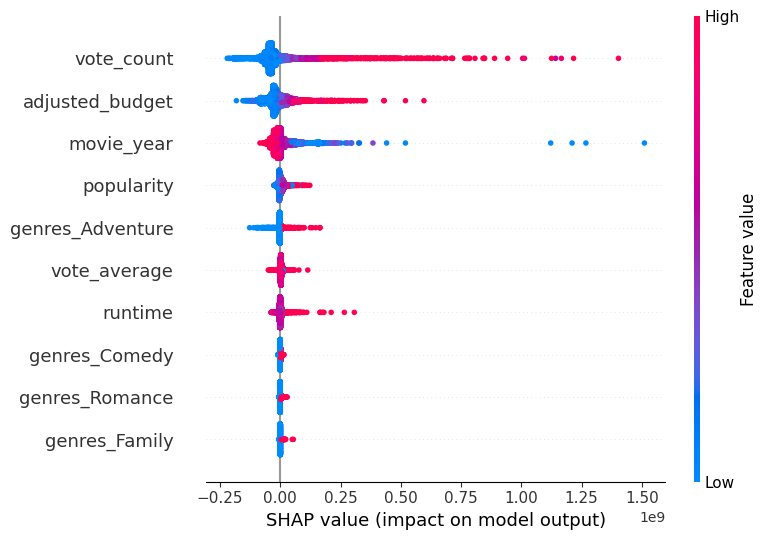

In [44]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, max_display=10)

### Separated for based on Book

In [45]:
# param_grid = {
#     'n_estimators': [200, 250, 300, 350], #it always picks the highest one so we do not need to redo the tuning for low number of estimators
#     'max_depth': [5, 10, 20, None],  
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 5],  
#     'bootstrap': [True]                  
# }
#best_params = gu.random_forest_grid_search(X_train_based_on_book, y_train_based_on_book, param_grid)
best_params_based_on_book = {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 250}
print('Best parameters:', best_params_based_on_book)

Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 250}


In [46]:
feature_importances, best_model = gu.train_model_with_best_params(X_train_based_on_book, X_test_based_on_book, y_train_based_on_book, y_test_based_on_book, best_params)

Validation error (RMSE): 619833132.8157822
R^2 Score: 0.15995207816343393


In [47]:
gu.create_interactive_bar_chart(feature_importances, "Random Forest Importances of Bobs")

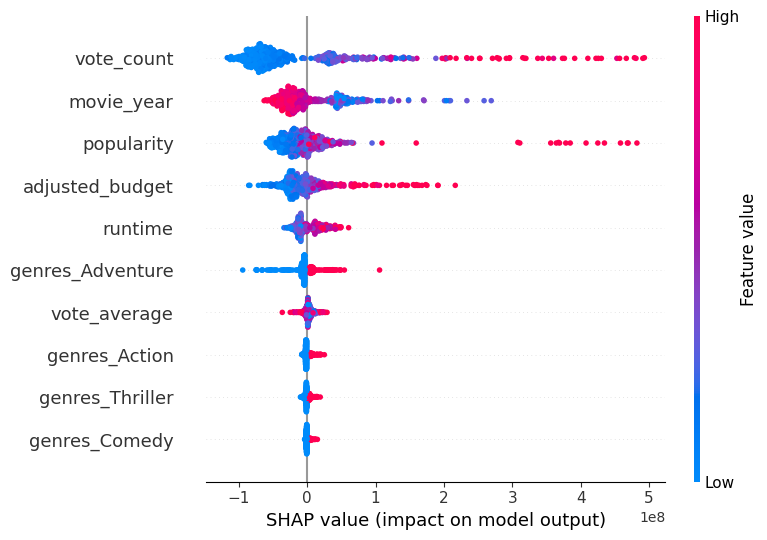

In [48]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_based_on_book)

shap.summary_plot(shap_values, X_train_based_on_book, max_display=10)

### Not based on book

Here there is probably no need to redo the hyperparameter tuning since we can achieve a higher R^2 value already

In [49]:
feature_importances, best_model=gu.train_model_with_best_params(X_train_not_based_on_book, X_test_not_based_on_book, y_train_not_based_on_book, y_test_not_based_on_book, best_params)

Validation error (RMSE): 102978588.93473381
R^2 Score: 0.6466890703560536


In [50]:
gu.create_interactive_bar_chart(feature_importances, "Random Forest Importances of Nobs")

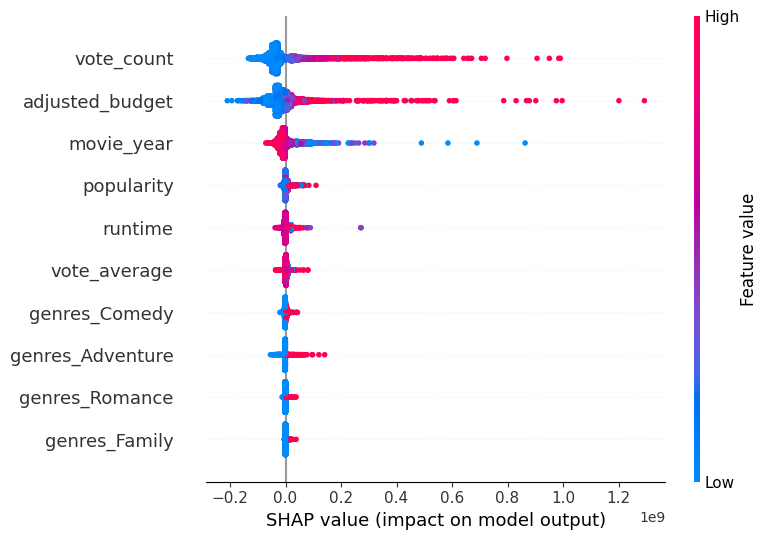

In [51]:

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_not_based_on_book)

shap.summary_plot(shap_values, X_train_not_based_on_book, max_display=10)


## Propensity Score Calculation and Matching 

In [52]:
X_not_book, X_book = gu.standardize_dataset_matching(matching_dataset_processed_df)

658


In [53]:
#Coefficients extracted from random forest classifier 
#Signs adjusted by linear regression 
coeffs = [0.4603, -0.2067, 0.1360, 0.0585, 0.0387, -0.0282, 0.0256, -0.0049]

# Calculate Propensity scores based on the coefficients
X_book["Propensity"] = gu.calculate_propensity_score(X_book, coeffs)
X_not_book["Propensity"] = gu.calculate_propensity_score(X_not_book,coeffs)

# Matching algorithm to create Bob and Nob pairs
pairs=gu.matching(X_not_book, X_book)
print("Out of %d Bobs, %d were matched" % (len(X_book), len(pairs)))

Out of 658 Bobs, 434 were matched


The revenue of the book based film was better for a total of 253 times out of 434 (ratio 0.5829)
The median difference of revenues (Bob - Nob) is 10706696 $ while the mean is 31327180 $
The revenue of the book based film was better for a total of 253 times out of 434 (ratio 0.5829)


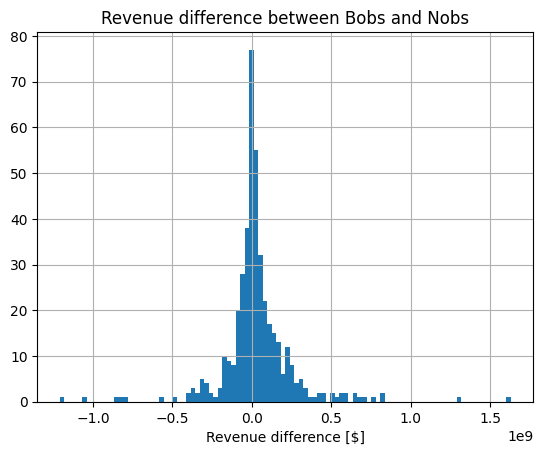

In [54]:
# Creating the histogram that shows the difference of revenues between the matched Bobs and Nobs
total_rev, book_perc = gu.create_histogram_matching(X_not_book, X_book, pairs)

In [55]:
# Creating a box plot showing the difference between all the Bobs and all the Nobs that were matched
# Contrary to before it only considers the two datasets without the specific matches
gu.boxplot_matching(X_not_book, X_book, pairs)

In [56]:
# Extracting the matches where the total revue is maximal. This helps finding pairs that are interesting
# since they include well known movies
quizz_films = gu.extract_films_quizz(X_not_book, X_book,pairs, total_rev, book_perc,10)
display(quizz_films)

,BOB Title,NOB Title,Difference,BOB Revenue,NOB Revenue
0,Gone with the Wind,Cinderella,4.255648e+09,6.848513e+09,2.592865e+09
1,Jaws,Mulan,1.628411e+09,2.070373e+09,4.419627e+08
2,Pinocchio,Saw,1.294405e+09,1.424642e+09,1.302373e+08
3,The Lord of the Rings: The Fellowship of the Ring,Pulp Fiction,8.233814e+08,1.165010e+09,3.416284e+08
4,Love Story,Melancholia,8.149189e+08,8.317016e+08,1.678263e+07
5,Song of the South,The Bride Wore Red,7.686958e+08,7.884467e+08,1.975087e+07
6,Dances with Wolves,Raging Bull,7.025395e+08,7.686121e+08,6.607259e+07
7,Harry Potter and the Goblet of Fire,The Wolf of Wall Street,6.876929e+08,1.086052e+09,3.983591e+08
8,The Da Vinci Code,The Social Network,6.574894e+08,9.016785e+08,2.441891e+08
9,Jaws 2,Dredd,6.395294e+08,6.818437e+08,4.231435e+07


## Regression Books 

In [57]:
# from utils.regression_utils import merge_and_clean_sim
# #This function can be used to merge the dataset with the similarity scores. 
# #Since there are a lot of Nan values in the similarity column, the nan values are dropped. If we want to do it on the entire dataset, books_movies_adj can be merged directly with the book genres. 
# merged_df = merge_and_clean_sim(books_movies_adj)

book_movies_adj = df_revenue.copy(deep=True)
book_ids = book_movies_adj[['book_id', 'movie_id', 'adjusted_revenue']]
book_genres_df = book_genres.groupby('book_id')['genre'].apply(lambda x: ', '.join(x)).reset_index()
book_sim_genres = book_ids.merge(book_genres_df[['book_id', 'genre']], on= 'book_id', how= 'inner')
print(len(book_sim_genres))
books_df_final = books_features_preprocessing(book_sim_genres=book_sim_genres)
books_df_final.columns

657


Index(['book_id', 'movie_id', 'adjusted_revenue', 'genre', 'title', 'year',
       'avg_rating', 'rating_count', 'review_count', 'series', 'series_num',
       'author', 'description', 'length', 'five_stars', 'four_stars',
       'three_stars', 'two_stars', 'one_star', 'cover_image',
       'standardized_rating', 'normalized_rating', 'part_of_series',
       'one_star_percentage', 'two_stars_percentage', 'three_stars_percentage',
       'four_stars_percentage', 'five_stars_percentage'],
      dtype='object')

In [58]:
# how to keep information about the autor? We will take out the series_num because many nan, might change later
books_df_final.drop(columns=['movie_id', 'book_id', 'title', 'series', 'series_num', 'author', 'description', 'cover_image', 'five_stars', 'four_stars', 'three_stars', 'two_stars', 'one_star'], inplace=True)
books_df_final.columns
books_regression = multi_one_hot_encode_columns(
    books_df_final,
    column_names_mohe=['genre'], 
    threshold=50
)
books_regression.dropna(inplace=True)

In [59]:
X_train, X_test, y_train, y_test = create_train_test_split(
    books_regression, 
    target_column='adjusted_revenue', 
    should_split_based_on_book=False, 
    test_size=0.2, 
    seed=42
)['all']

In [60]:
results = gu.perform_linear_regression(X_train, X_test, y_train, y_test)
results.summary()

RMSE value: 614875256.207257


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     7.590
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           5.54e-23
Time:                        14:47:02   Log-Likelihood:                -10493.
No. Observations:                 508   AIC:                         2.104e+04
Df Residuals:                     481   BIC:                         2.115e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.807e+08   1.03e+07     17.517      0.000     1.6e+08    2.01e+08
year                    1.333e+07   1.09e+07      1.225      0.221   -8.05e+06    3.47e+07
avg_rating              -1.38e+08   3.14e+08     -0.439      0.661   -7.55e+08    4.79e+08
rating_count            1.629e+08   3.17e+07      5.146      0.000    1.01e+08    2.25e+08
review_count           -1.177e+08   3.05e+07     -3.859      0.000   -1.78e+08   -5.78e+07
length                  6.542e+06   1.25e+07      0.524      0.600    -1.8e+07    3.11e+07
standardized_rating     -1.38e+08   3.14e+08     -0.439      0.661   -7.55e+08    4.79e+08
normalized_rating       -1.38e+08   3.14e+08     -0.439      0.661   -7.55e+08    4.79e+08
part_of_series           4.05e+07   1.16e+07      3.484      0.001    1.77e+07    6.33e+07
one_star_percentage    -1.207e+08    2.4e+08     -0.503      0.615   -5.92e+08    3.51e+08
two_stars_percentage    -1.13e+08   2.62e+08     -0.431      0.667   -6.28e+08    4.02e+08
three_stars_percentage -1.305e+08   2.87e+08     -0.455      0.650   -6.94e+08    4.34e+08
four_stars_percentage  -2.542e+07   2.48e+07     -1.025      0.306   -7.41e+07    2.33e+07
five_stars_percentage   1.615e+08   3.37e+08      0.479      0.632   -5.01e+08    8.24e+08
genre_count            -1.157e+07   1.84e+07     -0.630      0.529   -4.77e+07    2.45e+07
genre_Adventure         4.861e+07   1.27e+07      3.817      0.000    2.36e+07    7.36e+07
genre_Childrens        -1.335e+07    1.4e+07     -0.955      0.340   -4.08e+07    1.41e+07
genre_Classics          3.301e+07   1.33e+07      2.479      0.014    6.84e+06    5.92e+07
genre_Crime            -2.882e+07   1.72e+07     -1.678      0.094   -6.26e+07    4.93e+06
genre_Cultural         -1.378e+07   1.35e+07     -1.023      0.307   -4.03e+07    1.27e+07
genre_Fantasy            3.24e+07   1.31e+07      2.477      0.014     6.7e+06    5.81e+07
genre_Fiction            5.37e+06   1.14e+07      0.473      0.637    -1.7e+07    2.77e+07
genre_Historical        -1.17e+06   1.35e+07     -0.087      0.931   -2.77e+07    2.54e+07
genre_Horror             7.91e+06   1.18e+07      0.669      0.504   -1.53e+07    3.11e+07
genre_Literature       -2.592e+07    1.4e+07     -1.846      0.065   -5.35e+07    1.67e+06
genre_Mystery          -1.229e+06   1.86e+07     -0.066      0.947   -3.79e+07    3.54e+07
genre_Romance           4.843e+05   1.21e+07      0.040      0.968   -2.33e+07    2.43e+07
genre_Science Fiction  -2.584e+07   1.26e+07     -2.059      0.040   -5.05e+07   -1.18e+06
genre_Thriller          4.921e+07    1.6e+07      3.073      0.002    1.77e+07    8.07e+07
genre_Young Adult      -1.566e+07   1.31e+07     -1.192      0.234   -4.15e+07    1.02e+07
==============================================================================
O

In [61]:
gu. create_error_plot_regression(results,"Linear Regression of Books", threshold_p_values=0.1, color_palette=gu.color_palette_book_reg_lin)

### Random Forest Books 

In [62]:
# param_grid = {
#     'n_estimators': [2, 5, 10, 25, 100, 150],
#     'max_depth': [10, 15, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [2, 4, 6, 8],
#     'bootstrap': [False, True]
# }
#best_params=gu.random_forest_grid_search(X_train, y_train, param_grid)
best_params = {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
print('Best parameters:', best_params)

Best parameters: {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [63]:
feature_importances, best_model =gu.train_model_with_best_params(X_train, X_test, y_train, y_test, best_params)

Validation error (RMSE): 3.732345564335084e+17
R^2 Score: 0.10574117158378515


In [64]:
gu.create_interactive_bar_chart(feature_importances, "Random forest Importances of Books", color_palette=gu.color_palette_book_reg_lin)

In [65]:
coefficients = results.params
p_values = results.pvalues
coeff_df = pd.DataFrame({
    'Coefficient': coefficients,
    'P-Value': p_values
})
coeff_df['Feature'] = coeff_df.index
# Display the DataFrame
display(coeff_df)

,Coefficient,P-Value,Feature
const,1.806674e+08,1.681699e-53,const
year,1.332740e+07,2.210841e-01,year
avg_rating,-1.379575e+08,6.608375e-01,avg_rating
rating_count,1.629259e+08,3.891142e-07,rating_count
review_count,-1.176848e+08,1.291290e-04,review_count
length,6.541781e+06,6.004890e-01,length
standardized_rating,-1.379575e+08,6.608375e-01,standardized_rating
normalized_rating,-1.379575e+08,6.608375e-01,normalized_rating
part_of_series,4.050347e+07,5.388993e-04,part_of_series
one_star_percentage,-1.206862e+08,6.152776e-01,one_star_percentage


In [66]:
combined_features = feature_importances.merge(coeff_df, on = 'Feature', how='inner')

In [67]:
display(combined_features)

,Feature,Importance,Coefficient,P-Value
0,three_stars_percentage,0.241020,-1.304659e+08,6.496545e-01
1,rating_count,0.083241,1.629259e+08,3.891142e-07
2,genre_Thriller,0.069629,4.921387e+07,2.238810e-03
3,part_of_series,0.066994,4.050347e+07,5.388993e-04
4,review_count,0.057545,-1.176848e+08,1.291290e-04
5,genre_Adventure,0.056452,4.861413e+07,1.529006e-04
6,five_stars_percentage,0.047727,1.615472e+08,6.318696e-01
7,normalized_rating,0.044718,-1.379575e+08,6.608375e-01
8,year,0.044168,1.332740e+07,2.210841e-01
9,length,0.036434,6.541781e+06,6.004890e-01


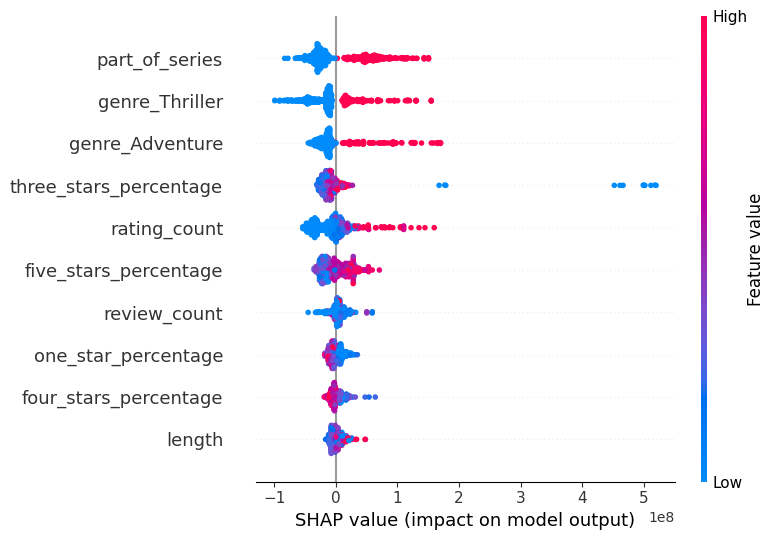

In [68]:
import shap

# Assuming you have a trained Random Forest model `rf_model` and your data is `X_train`
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, max_display=10)

## Extraction Most Important Features

For the final analysis of important features we used both book and movie features combined with the similarity score between summaries of books and movies. 

In [69]:
#This function can be used to merge the dataset with the similarity scores. 
#Since there are a lot of Nan values in the similarity column, the nan values are dropped. If we want to do it on the entire dataset, books_movies_adj can be merged directly with the book genres. 
merged_df = merge_and_clean_sim(df_revenue)

In [70]:
# Matching books with their genres that are stored in a different .csv and then preprocessing the features
book_ids = merged_df[['book_id', 'movie_id', 'tmdb_id', 'adjusted_revenue', 'adjusted_budget', 'movie_year', 'runtime_y',  'film_sentiment', 'film_sentiment_score', 'book_sentiment', 'book_sentiment_score', 'similarity']]
book_genres_df = book_genres.groupby('book_id')['genre'].apply(lambda x: ', '.join(x)).reset_index()
book_sim_genres = book_ids.merge(book_genres_df[['book_id', 'genre']], on= 'book_id', how= 'inner')
books_df_final = books_features_preprocessing(book_sim_genres=book_sim_genres)

In [71]:
# Selecting which features are unnecessary, to reduce the computational burden
books_df_final.drop(columns=['movie_id', 'book_id', 'title', 'series', 'series_num', 'author', 'description', 'cover_image', 'five_stars', 'four_stars', 'three_stars', 'two_stars', 'one_star'], inplace=True)
books_regression = multi_one_hot_encode_columns( 
    books_df_final,
    column_names_mohe=['genre'], # Multi hot encoding is only done for the genre because this is the only one that is needed
    threshold=50,
    column_names_ohe=['book_sentiment', 'film_sentiment'] # Converting "Positive" and "Negative" to Trues and Wrongs
)
# Selecting the most important features that were found before
book_values_df = books_regression[['three_stars_percentage', 'rating_count', 'genre_Thriller', 'part_of_series',
 'review_count' ,'genre_Adventure' ,'five_stars_percentage',
 'normalized_rating' ,'year', 'book_sentiment_positive', 'book_sentiment_score', 'similarity', 'tmdb_id', 'film_sentiment_positive', 'film_sentiment_score', 'adjusted_budget', 'adjusted_revenue', 'runtime_y', 'movie_year']].copy()
book_values_df.rename(columns={'tmdb_id':'id'}, inplace=True)


In [72]:
# here we can use the regression dataset processed before for linear regression
# It is then merged with the book dataset based on the tmdb id
final_regression_df = book_values_df.merge(final_regression_dataset[["vote_average", "vote_count", "popularity", "genres_Adventure", "genres_count", "id"]], on= 'id', how= 'inner')
final_regression_df.drop(columns=['id'], inplace=True)
# Renaming the columns to limit confusion about variables that are named the same way
final_regression_df.rename(columns={'rating_count':'book_rating_count', 'review_count':'book_review_count', 'genre_Adventure':'book_genre_adventure', 'genre_Thriller':'book_genre_thriller', 'normalized_rating':'book_normalized_rating', 'year':'book_year', 'runtime_y':'movie_runtime', 'vote_average':'movie_vote_average', 'vote_count':'movie_vote_count', 'popularity':'movie_popularity', 'film_sentiment_positive':'movie_sentiment_positive', 'film_sentiment_score':'movie_sentiment_score', 'genres_Adventure':'movie_genre_adventure', 'genres_count':'movie_genres_count', 'three_stars_percentage':'book_3_stars_percentage', 'part_of_series':'book_in_series', 'five_stars_percentage':'book_5_starts_percentage', 'adjusted_revenue':'movie_adjusted_revenue', 'adjusted_budget':'movie_adjusted_budget'}, inplace=True)
final_regression_df['sentiment_difference'] = final_regression_df['movie_sentiment_score'] - final_regression_df["book_sentiment_score"]

In [73]:
split_dict = create_train_test_split(
    final_regression_df,
    target_column='movie_adjusted_revenue',
    should_split_based_on_book=False,
    test_size=0.2,
    seed=42
)
X_train, X_test, y_train, y_test = split_dict['all']

In [74]:
results = gu.perform_linear_regression(X_train, X_test, y_train, y_test)
results.summary()

RMSE value: 734464420.2763523


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     17.26
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           1.17e-40
Time:                        14:47:06   Log-Likelihood:                -6426.0
No. Observations:                 313   AIC:                         1.290e+04
Df Residuals:                     290   BIC:                         1.298e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     2.073e+08   1.17e+07     17.694      0.000    1.84e+08     2.3e+08
book_3_stars_percentage    5.71e+07   4.54e+07      1.258      0.209   -3.22e+07    1.46e+08
book_rating_count         6.288e+06   3.82e+07      0.165      0.869   -6.89e+07    8.15e+07
book_genre_thriller       3.526e+07   1.35e+07      2.613      0.009     8.7e+06    6.18e+07
book_in_series            4.441e+07    1.3e+07      3.416      0.001    1.88e+07       7e+07
book_review_count        -1.787e+07   3.57e+07     -0.500      0.617   -8.82e+07    5.24e+07
book_genre_adventure      3.502e+07   1.57e+07      2.235      0.026    4.19e+06    6.59e+07
book_5_starts_percentage  3.562e+07   5.02e+07      0.710      0.478   -6.31e+07    1.34e+08
book_normalized_rating     1.02e+06   3.91e+07      0.026      0.979    -7.6e+07     7.8e+07
book_year                 4.647e+06   1.27e+07      0.366      0.715   -2.04e+07    2.96e+07
book_sentiment_positive   6.399e+06    2.3e+07      0.279      0.781   -3.88e+07    5.16e+07
book_sentiment_score      1.335e+06   1.73e+07      0.077      0.939   -3.28e+07    3.54e+07
similarity                2.331e+07   1.28e+07      1.818      0.070   -1.92e+06    4.85e+07
movie_sentiment_positive  3.988e+06   2.11e+07      0.189      0.850   -3.75e+07    4.55e+07
movie_sentiment_score    -3.987e+06   1.52e+07     -0.263      0.793   -3.38e+07    2.58e+07
movie_adjusted_budget     6.698e+07   1.53e+07      4.379      0.000    3.69e+07    9.71e+07
movie_runtime             2.001e+07   1.28e+07      1.560      0.120   -5.24e+06    4.53e+07
movie_year               -4.602e+07   1.42e+07     -3.252      0.001   -7.39e+07   -1.82e+07
movie_vote_average        1.393e+07   1.75e+07      0.796      0.427   -2.05e+07    4.84e+07
movie_vote_count          8.352e+07   2.29e+07      3.653      0.000    3.85e+07    1.29e+08
movie_popularity          6.943e+07   2.11e+07      3.287      0.001    2.79e+07    1.11e+08
movie_genre_adventure     2.634e+07   1.69e+07      1.558      0.120   -6.94e+06    5.96e+07
movie_genres_count       -3.382e+07   1.36e+07     -2.492      0.013   -6.05e+07   -7.11e+06
sentiment_difference     -4.469e+06   1.16e+07     -0.386      0.700   -2.73e+07    1.83e+07
==============================================================================
Omnibus:                      245.632   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6272.918
Skew:                           2.931   Prob(JB):                         0.00
Kurtosis:                      24.134   Cond. No.                     9.10e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified

In [75]:
# Visualizing the regression results. It is important to mention that all the sentiment score values have such 
# a low weight that they are not considered important enough to be included in the datastory.
gu.create_error_plot_regression(results, "Linear Regression of Book and Movie Features",threshold_p_values = 0.1, color_palette = gu.color_palette_1)

## Final Random Forest 

In [76]:
# param_grid = {
#     'n_estimators': [2, 5, 10, 25, 100, 150],
#     'max_depth': [10, 15, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [2, 4, 6, 8],
#     'bootstrap': [False, True]
# }

#best_params=gu.random_forest_grid_search(X_train, y_train, param_grid)
best_params = {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
print('Best parameters:', best_params)

Best parameters: {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [77]:
feature_importances, best_model=gu.train_model_with_best_params(X_train, X_test, y_train, y_test, best_params)

Validation error (RMSE): 5.547278580560966e+17
R^2 Score: 0.129163189703297


In [78]:
gu.create_interactive_bar_chart(feature_importances, "Random Forest Importances of Book and Movie Features", color_palette=gu.color_palette_1)


In [79]:
coefficients = results.params
p_values = results.pvalues
coeff_df = pd.DataFrame({
    'Coefficient': coefficients,
    'P-Value': p_values
})
coeff_df['Feature'] = coeff_df.index

combined_features = feature_importances.merge(coeff_df, on = 'Feature', how='inner')

# Datafram to compare coefficients from linear regression with the importance in the random forest
display(combined_features)

,Feature,Importance,Coefficient,P-Value
0,movie_vote_count,0.347658,8.352477e+07,3.079894e-04
1,movie_popularity,0.216703,6.942735e+07,1.136062e-03
2,movie_adjusted_budget,0.104173,6.698392e+07,1.666164e-05
3,movie_year,0.076855,-4.602019e+07,1.283356e-03
4,movie_genre_adventure,0.054310,2.634127e+07,1.203520e-01
5,similarity,0.028131,2.330773e+07,7.002451e-02
6,book_3_stars_percentage,0.026571,5.710351e+07,2.092652e-01
7,book_genre_adventure,0.025350,3.502139e+07,2.615115e-02
8,book_5_starts_percentage,0.020039,3.562310e+07,4.780896e-01
9,movie_vote_average,0.018281,1.393450e+07,4.267460e-01


## Analyse Books that has been adapted multiple times

In [80]:
#First the similarity scores are added to the dataset
books_movie_dataset_n= pd.merge(df_revenue, similarites_df, on = 'movie_id', how ='left')
#All the rows with missing similarity scores are dropped
books_movie_dataset_n.dropna(subset='similarity', inplace=True)
#The features of interest are chosen and renamed for plotting purposes
relevant_columns = ['BookTitle','runtime_y','adjusted_budget','adjusted_revenue','movie_name_x','movie_year','similarity']
relevant_movies = books_movie_dataset_n[relevant_columns]
relevant_movies= relevant_movies.rename(columns={"BookTitle": "BookTitle", "runtime_y": "Runtime", "movie_name_x": "Movie Name", "movie_year": "Release Year", 
                                "similarity": "Similarity", "adjusted_budget": "Budget","adjusted_revenue": "Box Office Revenue"  })

gu.bar_plot_multiple_adaptations(relevant_movies)
#This function creates 4 datasets containing all books with at least 2,3,4 and 5 movies based on them. 
#The movies features are than standardized with respect to the other movies based on the same book.
#The best performing movies (Revenue over 0 after standartisation) are then plotted in a boxplot with their
#standardised features.